# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# Load pickled data
import pickle
import numpy as np
from scipy import ndimage
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import matplotlib.gridspec as gridspec
import random

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
train_features, train_labels = train['features'], train['labels']
test_features, test_labels = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(train_features)

# TODO: number of testing examples
n_test = len(test_features)

# TODO: what's the shape of an image?
image_shape = train_features.shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(test_labels))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


In [3]:
#Print the 43 class label names
signname_map = np.genfromtxt('signnames.csv', skip_header=1, delimiter=',', usecols=(1,), unpack=True, dtype=str)


# Use the mapping array to print the SignName.
predictions = np.unique(test_labels)
predict_signNames = []
for id in predictions:
    predict_signNames.append(signname_map[int(id)])
print(predict_signNames)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vechiles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vechiles', 'Vechiles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vechiles over 3.5 metric tons']


In [4]:
test_features.shape

(12630, 32, 32, 3)

Sample test images: 100%|██████████| 43/43 [01:01<00:00,  1.41s/labels]


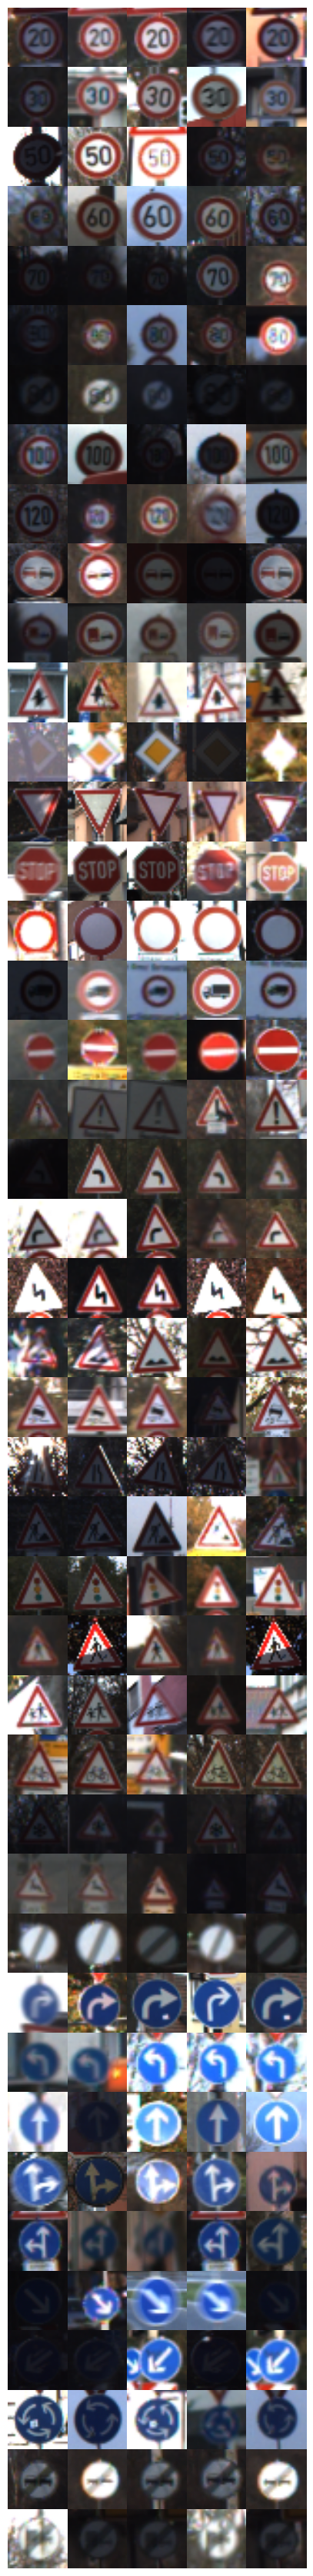

In [5]:
# This print routine was written by my October cohort John Chen and posted on Atlassian
# Using the test data five samples for each of the Forty three classes are plotted
sample_size = 5 #five image per class label
n_labels = 43
count = 0 #book keeping for plots
fig = plt.figure(figsize=(sample_size, n_labels))
grid = gridspec.GridSpec(n_labels, sample_size, wspace=0.0, hspace=0.0)
labelset_pbar = tqdm(range(n_labels), desc='Sample test images', unit='labels')
for i in labelset_pbar:
    ind = test_labels == i
    subset_x =test_features [ind,] #get all images that belong to class i
    for x in range(sample_size):
        img = random.choice(subset_x) #randomly pick on image from class i
        ax = plt.Subplot(fig, grid[count])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        fig.add_subplot(ax)
        count +=1

    # hide the borders
    if i == (n_labels-1):
        all_axes = fig.get_axes()
        for ax in all_axes:
            for sp in ax.spines.values():
                sp.set_visible(False)
plt.show()

In [6]:
# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

In [7]:
#Implement Min-Max scaling for image data
def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

if not is_features_normal:
    train_features = normalize(train_features)
    test_features = normalize(test_features)
    is_features_normal = True

print('Tests Passed!')



Tests Passed!


In [8]:
from sklearn.preprocessing import OneHotEncoder

def OHE_labels(Y_t,N_classes):
    OHC = OneHotEncoder()
    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_t.reshape(-1, 1)).toarray()
    
    return Y_labels


train_labels = OHE_labels(train_labels,43)
test_labels = OHE_labels(test_labels,43)
is_labels_encod = True
print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [9]:
#flatten test and train features
train_features = train_features.reshape(-1, 32*32*3)
test_features = test_features.reshape(-1, 32*32*3)
train_features = train_features.reshape(-1, 32*32*3)

In [10]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.10,
    random_state=0)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [11]:
#Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
train_features = train_features.astype(np.float32)
test_features = test_features.astype(np.float32)
valid_features = valid_features.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)

In [12]:
valid_features.shape

(6666, 3072)

In [13]:
### Data exploration visualization goes here.


In [14]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
features_count = 32*32*3
labels_count = 43

#Set the features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# Problem 2 - Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))


In [15]:
#Error detection section
#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == None or (\
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, features_count]), 'The shape of features is incorrect'
assert labels._shape in [None, labels_count], 'The shape of labels is incorrect'
assert weights._variable._shape == (features_count, labels_count), 'The shape of weights is incorrect'
assert biases._variable._shape == (labels_count), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

In [16]:
# Feed dicts for training, validation, and test session#valid_feed_dict = {features: valid_features, labels: valid_labels}

train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy

cross_entropy = tf.reduce_mean(-tf.reduce_sum(labels * tf.log(tf.clip_by_value(prediction,1e-10,1.0)), 
                                              reduction_indices=[1]))


# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

In [17]:
loss

<tf.Tensor 'Mean_1:0' shape=<unknown> dtype=float32>

In [18]:
labels

<tf.Tensor 'Placeholder_1:0' shape=<unknown> dtype=float32>

In [19]:
features

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=float32>

In [20]:
# Test Cases
with tf.Session() as session:
    session.run(init) 
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


In [21]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


Epoch  1/100: 100%|██████████| 1628/1628 [00:26<00:00, 62.55batches/s]


Validation accuracy at 0.3232823312282562 Training accuracy at 0.3086685240268707


Epoch  2/100: 100%|██████████| 1628/1628 [00:27<00:00, 59.74batches/s]


Validation accuracy at 0.5616561770439148 Training accuracy at 0.5611037611961365


Epoch  3/100: 100%|██████████| 1628/1628 [00:30<00:00, 53.42batches/s]


Validation accuracy at 0.5991598963737488 Training accuracy at 0.6029868125915527


Epoch  4/100: 100%|██████████| 1628/1628 [00:30<00:00, 53.96batches/s]


Validation accuracy at 0.6938194036483765 Training accuracy at 0.7085701823234558


Epoch  5/100: 100%|██████████| 1628/1628 [00:30<00:00, 53.88batches/s]


Validation accuracy at 0.7419741749763489 Training accuracy at 0.7568140625953674


Epoch  6/100: 100%|██████████| 1628/1628 [00:30<00:00, 53.18batches/s]


Validation accuracy at 0.7839784026145935 Training accuracy at 0.7960544228553772


Epoch  7/100: 100%|██████████| 1628/1628 [00:30<00:00, 53.76batches/s]


Validation accuracy at 0.7473747134208679 Training accuracy at 0.7587807178497314


Epoch  8/100: 100%|██████████| 1628/1628 [00:31<00:00, 51.33batches/s]


Validation accuracy at 0.7685268521308899 Training accuracy at 0.7869280576705933


Epoch  9/100: 100%|██████████| 1628/1628 [00:32<00:00, 50.57batches/s]


Validation accuracy at 0.7805280685424805 Training accuracy at 0.7958086133003235


Epoch 10/100: 100%|██████████| 1628/1628 [00:33<00:00, 48.82batches/s]


Validation accuracy at 0.8184818625450134 Training accuracy at 0.8415634632110596


Epoch 11/100: 100%|██████████| 1628/1628 [00:33<00:00, 49.03batches/s]


Validation accuracy at 0.8454845547676086 Training accuracy at 0.86725252866745


Epoch 12/100: 100%|██████████| 1628/1628 [00:34<00:00, 47.78batches/s]


Validation accuracy at 0.8586858510971069 Training accuracy at 0.8808960318565369


Epoch 13/100: 100%|██████████| 1628/1628 [00:34<00:00, 46.93batches/s]


Validation accuracy at 0.8553855419158936 Training accuracy at 0.8779460787773132


Epoch 14/100: 100%|██████████| 1628/1628 [00:36<00:00, 45.15batches/s]


Validation accuracy at 0.8615361452102661 Training accuracy at 0.8885474801063538


Epoch 15/100: 100%|██████████| 1628/1628 [00:34<00:00, 47.18batches/s]


Validation accuracy at 0.8570356965065002 Training accuracy at 0.8819408416748047


Epoch 16/100: 100%|██████████| 1628/1628 [00:33<00:00, 47.98batches/s]


Validation accuracy at 0.8601860404014587 Training accuracy at 0.8852287530899048


Epoch 17/100: 100%|██████████| 1628/1628 [00:34<00:00, 47.54batches/s]


Validation accuracy at 0.8681368231773376 Training accuracy at 0.8935562372207642


Epoch 18/100: 100%|██████████| 1628/1628 [00:33<00:00, 48.46batches/s]


Validation accuracy at 0.8724872469902039 Training accuracy at 0.8988415598869324


Epoch 19/100: 100%|██████████| 1628/1628 [00:35<00:00, 46.34batches/s]


Validation accuracy at 0.8760876059532166 Training accuracy at 0.9046492576599121


Epoch 20/100: 100%|██████████| 1628/1628 [00:34<00:00, 47.74batches/s]


Validation accuracy at 0.8774377703666687 Training accuracy at 0.9057247042655945


Epoch 21/100: 100%|██████████| 1628/1628 [00:34<00:00, 46.70batches/s]


Validation accuracy at 0.8799880146980286 Training accuracy at 0.9079371690750122


Epoch 22/100: 100%|██████████| 1628/1628 [00:36<00:00, 54.94batches/s]


Validation accuracy at 0.8849384784698486 Training accuracy at 0.9136527180671692


Epoch 23/100: 100%|██████████| 1628/1628 [00:36<00:00, 44.60batches/s]


Validation accuracy at 0.8909391164779663 Training accuracy at 0.9166026711463928


Epoch 24/100: 100%|██████████| 1628/1628 [00:34<00:00, 47.72batches/s]


Validation accuracy at 0.8904890418052673 Training accuracy at 0.9160495400428772


Epoch 25/100: 100%|██████████| 1628/1628 [00:35<00:00, 57.22batches/s]


Validation accuracy at 0.8888388872146606 Training accuracy at 0.9157729744911194


Epoch 26/100: 100%|██████████| 1628/1628 [00:37<00:00, 43.41batches/s]


Validation accuracy at 0.8915391564369202 Training accuracy at 0.919153094291687


Epoch 27/100: 100%|██████████| 1628/1628 [00:40<00:00, 33.90batches/s]


Validation accuracy at 0.8951395153999329 Training accuracy at 0.9226254224777222


Epoch 28/100: 100%|██████████| 1628/1628 [00:44<00:00, 36.93batches/s]


Validation accuracy at 0.8943894505500793 Training accuracy at 0.9225639700889587


Epoch 29/100: 100%|██████████| 1628/1628 [00:38<00:00, 47.00batches/s]


Validation accuracy at 0.8982897996902466 Training accuracy at 0.9280951619148254


Epoch 30/100: 100%|██████████| 1628/1628 [00:41<00:00, 39.22batches/s]


Validation accuracy at 0.8982897996902466 Training accuracy at 0.9251452088356018


Epoch 31/100: 100%|██████████| 1628/1628 [00:39<00:00, 41.52batches/s]


Validation accuracy at 0.8991898894309998 Training accuracy at 0.9263743162155151


Epoch 32/100: 100%|██████████| 1628/1628 [00:39<00:00, 41.50batches/s]


Validation accuracy at 0.9015901684761047 Training accuracy at 0.9288633465766907


Epoch 33/100: 100%|██████████| 1628/1628 [00:36<00:00, 44.92batches/s]


Validation accuracy at 0.9017401933670044 Training accuracy at 0.9289247989654541


Epoch 34/100: 100%|██████████| 1628/1628 [00:36<00:00, 44.39batches/s]


Validation accuracy at 0.901890218257904 Training accuracy at 0.9302768707275391


Epoch 35/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.56batches/s]


Validation accuracy at 0.9056405425071716 Training accuracy at 0.935377836227417


Epoch 36/100: 100%|██████████| 1628/1628 [00:38<00:00, 41.83batches/s]


Validation accuracy at 0.9044404625892639 Training accuracy at 0.935224175453186


Epoch 37/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.72batches/s]


Validation accuracy at 0.9062406420707703 Training accuracy at 0.9368220567703247


Epoch 38/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.12batches/s]


Validation accuracy at 0.9006900787353516 Training accuracy at 0.9300003051757812


Epoch 39/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.60batches/s]


Validation accuracy at 0.9065406322479248 Training accuracy at 0.9359616637229919


Epoch 40/100: 100%|██████████| 1628/1628 [00:39<00:00, 41.57batches/s]


Validation accuracy at 0.9089409112930298 Training accuracy at 0.9407860636711121


Epoch 41/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.59batches/s]


Validation accuracy at 0.9102910161018372 Training accuracy at 0.9410011172294617


Epoch 42/100: 100%|██████████| 1628/1628 [00:40<00:00, 40.66batches/s]


Validation accuracy at 0.9083408117294312 Training accuracy at 0.9417693614959717


Epoch 43/100: 100%|██████████| 1628/1628 [00:39<00:00, 41.74batches/s]


Validation accuracy at 0.9087908864021301 Training accuracy at 0.9438896179199219


Epoch 44/100: 100%|██████████| 1628/1628 [00:39<00:00, 40.84batches/s]


Validation accuracy at 0.9102910161018372 Training accuracy at 0.9449958801269531


Epoch 45/100: 100%|██████████| 1628/1628 [00:39<00:00, 41.49batches/s]


Validation accuracy at 0.9108911156654358 Training accuracy at 0.9442890882492065


Epoch 46/100: 100%|██████████| 1628/1628 [00:39<00:00, 41.34batches/s]


Validation accuracy at 0.9135913848876953 Training accuracy at 0.9460713267326355


Epoch 47/100: 100%|██████████| 1628/1628 [00:39<00:00, 40.74batches/s]


Validation accuracy at 0.9129912853240967 Training accuracy at 0.9469624757766724


Epoch 48/100: 100%|██████████| 1628/1628 [00:40<00:00, 40.42batches/s]


Validation accuracy at 0.9096909761428833 Training accuracy at 0.9435515999794006


Epoch 49/100: 100%|██████████| 1628/1628 [00:40<00:00, 40.41batches/s]


Validation accuracy at 0.911791205406189 Training accuracy at 0.9439818263053894


Epoch 50/100: 100%|██████████| 1628/1628 [00:40<00:00, 40.04batches/s]


Validation accuracy at 0.9135913848876953 Training accuracy at 0.9461020827293396


Epoch 51/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.29batches/s]


Validation accuracy at 0.9137413501739502 Training accuracy at 0.9465323090553284


Epoch 52/100: 100%|██████████| 1628/1628 [00:40<00:00, 40.46batches/s]


Validation accuracy at 0.9140413999557495 Training accuracy at 0.9462557435035706


Epoch 53/100: 100%|██████████| 1628/1628 [00:40<00:00, 40.32batches/s]


Validation accuracy at 0.9122412204742432 Training accuracy at 0.9447807669639587


Epoch 54/100: 100%|██████████| 1628/1628 [00:39<00:00, 40.98batches/s]


Validation accuracy at 0.9165916442871094 Training accuracy at 0.9498202204704285


Epoch 55/100: 100%|██████████| 1628/1628 [00:40<00:00, 39.88batches/s]


Validation accuracy at 0.9162916541099548 Training accuracy at 0.9492056369781494


Epoch 56/100: 100%|██████████| 1628/1628 [00:40<00:00, 40.34batches/s]


Validation accuracy at 0.9168916940689087 Training accuracy at 0.9502504467964172


Epoch 57/100: 100%|██████████| 1628/1628 [00:40<00:00, 40.23batches/s]


Validation accuracy at 0.9146414399147034 Training accuracy at 0.9482837915420532


Epoch 58/100: 100%|██████████| 1628/1628 [00:39<00:00, 41.37batches/s]


Validation accuracy at 0.917191743850708 Training accuracy at 0.95111083984375


Epoch 59/100: 100%|██████████| 1628/1628 [00:39<00:00, 40.75batches/s]


Validation accuracy at 0.9135913848876953 Training accuracy at 0.9466552138328552


Epoch 60/100: 100%|██████████| 1628/1628 [00:39<00:00, 41.74batches/s]


Validation accuracy at 0.917191743850708 Training accuracy at 0.950066089630127


Epoch 61/100: 100%|██████████| 1628/1628 [00:40<00:00, 39.74batches/s]


Validation accuracy at 0.9179418087005615 Training accuracy at 0.9518175721168518


Epoch 62/100: 100%|██████████| 1628/1628 [00:41<00:00, 39.59batches/s]


Validation accuracy at 0.9134413599967957 Training accuracy at 0.9483452439308167


Epoch 63/100: 100%|██████████| 1628/1628 [00:39<00:00, 41.33batches/s]


Validation accuracy at 0.9189919233322144 Training accuracy at 0.9537842273712158


Epoch 64/100: 100%|██████████| 1628/1628 [00:38<00:00, 47.09batches/s]


Validation accuracy at 0.9180918335914612 Training accuracy at 0.9524014592170715


Epoch 65/100: 100%|██████████| 1628/1628 [00:39<00:00, 41.60batches/s]


Validation accuracy at 0.9194419384002686 Training accuracy at 0.9536920189857483


Epoch 66/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.31batches/s]


Validation accuracy at 0.9173417091369629 Training accuracy at 0.9529852867126465


Epoch 67/100: 100%|██████████| 1628/1628 [00:37<00:00, 43.55batches/s]


Validation accuracy at 0.9201920032501221 Training accuracy at 0.9559352397918701


Epoch 68/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.64batches/s]


Validation accuracy at 0.916741669178009 Training accuracy at 0.9521248936653137


Epoch 69/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.63batches/s]


Validation accuracy at 0.9174917340278625 Training accuracy at 0.952309250831604


Epoch 70/100: 100%|██████████| 1628/1628 [00:37<00:00, 43.82batches/s] 


Validation accuracy at 0.9176417589187622 Training accuracy at 0.9534769654273987


Epoch 71/100: 100%|██████████| 1628/1628 [00:36<00:00, 44.65batches/s]


Validation accuracy at 0.918691873550415 Training accuracy at 0.9533847570419312


Epoch 72/100: 100%|██████████| 1628/1628 [00:41<00:00, 39.44batches/s]


Validation accuracy at 0.9185418486595154 Training accuracy at 0.9537842273712158


Epoch 73/100: 100%|██████████| 1628/1628 [00:40<00:00, 39.93batches/s]


Validation accuracy at 0.9197419881820679 Training accuracy at 0.955474317073822


Epoch 74/100: 100%|██████████| 1628/1628 [00:41<00:00, 39.31batches/s]


Validation accuracy at 0.9197419881820679 Training accuracy at 0.9549826383590698


Epoch 75/100: 100%|██████████| 1628/1628 [00:41<00:00, 39.02batches/s]


Validation accuracy at 0.9179418087005615 Training accuracy at 0.9549826383590698


Epoch 76/100: 100%|██████████| 1628/1628 [00:41<00:00, 39.39batches/s]


Validation accuracy at 0.9219921827316284 Training accuracy at 0.9576560258865356


Epoch 77/100: 100%|██████████| 1628/1628 [00:41<00:00, 39.30batches/s]


Validation accuracy at 0.920642077922821 Training accuracy at 0.9565805196762085


Epoch 78/100: 100%|██████████| 1628/1628 [00:41<00:00, 39.17batches/s]


Validation accuracy at 0.9246924519538879 Training accuracy at 0.9595919251441956


Epoch 79/100: 100%|██████████| 1628/1628 [00:41<00:00, 39.22batches/s]


Validation accuracy at 0.9216921925544739 Training accuracy at 0.9579632878303528


Epoch 80/100: 100%|██████████| 1628/1628 [00:41<00:00, 39.24batches/s]


Validation accuracy at 0.9200419783592224 Training accuracy at 0.9565498232841492


Epoch 81/100: 100%|██████████| 1628/1628 [00:43<00:00, 37.27batches/s]


Validation accuracy at 0.9216921925544739 Training accuracy at 0.95710289478302


Epoch 82/100: 100%|██████████| 1628/1628 [00:41<00:00, 38.97batches/s]


Validation accuracy at 0.9212421178817749 Training accuracy at 0.9569492936134338


Epoch 83/100: 100%|██████████| 1628/1628 [00:43<00:00, 37.83batches/s]


Validation accuracy at 0.9209420680999756 Training accuracy at 0.9575638175010681


Epoch 84/100: 100%|██████████| 1628/1628 [00:39<00:00, 40.88batches/s]


Validation accuracy at 0.9213921427726746 Training accuracy at 0.957256555557251


Epoch 85/100: 100%|██████████| 1628/1628 [00:41<00:00, 39.30batches/s]


Validation accuracy at 0.9201920032501221 Training accuracy at 0.9567341804504395


Epoch 86/100: 100%|██████████| 1628/1628 [00:43<00:00, 37.66batches/s]


Validation accuracy at 0.9221422076225281 Training accuracy at 0.9569492936134338


Epoch 87/100: 100%|██████████| 1628/1628 [00:40<00:00, 40.30batches/s]


Validation accuracy at 0.9227422475814819 Training accuracy at 0.9577174782752991


Epoch 88/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.28batches/s]


Validation accuracy at 0.9218421578407288 Training accuracy at 0.9571643471717834


Epoch 89/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.31batches/s]


Validation accuracy at 0.9219921827316284 Training accuracy at 0.9582706093788147


Epoch 90/100: 100%|██████████| 1628/1628 [00:38<00:00, 41.94batches/s]


Validation accuracy at 0.9224422574043274 Training accuracy at 0.9580247402191162


Epoch 91/100: 100%|██████████| 1628/1628 [00:37<00:00, 42.99batches/s]


Validation accuracy at 0.9221422076225281 Training accuracy at 0.9584242105484009


Epoch 92/100: 100%|██████████| 1628/1628 [00:35<00:00, 45.99batches/s]


Validation accuracy at 0.9224422574043274 Training accuracy at 0.9594075679779053


Epoch 93/100: 100%|██████████| 1628/1628 [00:35<00:00, 45.98batches/s]


Validation accuracy at 0.9222922325134277 Training accuracy at 0.9594382643699646


Epoch 94/100: 100%|██████████| 1628/1628 [00:36<00:00, 44.06batches/s]


Validation accuracy at 0.922592282295227 Training accuracy at 0.9591002464294434


Epoch 95/100: 100%|██████████| 1628/1628 [00:39<00:00, 41.59batches/s]


Validation accuracy at 0.9239423871040344 Training accuracy at 0.9605752229690552


Epoch 96/100: 100%|██████████| 1628/1628 [00:35<00:00, 46.18batches/s]


Validation accuracy at 0.9236423373222351 Training accuracy at 0.9600836038589478


Epoch 97/100: 100%|██████████| 1628/1628 [00:38<00:00, 53.91batches/s]


Validation accuracy at 0.9245424270629883 Training accuracy at 0.9610669016838074


Epoch 98/100: 100%|██████████| 1628/1628 [00:37<00:00, 43.28batches/s]


Validation accuracy at 0.9236423373222351 Training accuracy at 0.9605445265769958


Epoch 99/100: 100%|██████████| 1628/1628 [00:39<00:00, 52.22batches/s]


Validation accuracy at 0.9248424768447876 Training accuracy at 0.9612205624580383


Epoch 100/100: 100%|██████████| 1628/1628 [00:38<00:00, 42.15batches/s]


Validation accuracy at 0.9252925515174866 Training accuracy at 0.9618658423423767


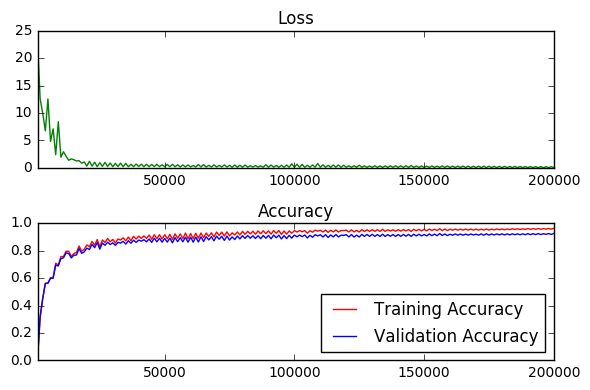

In [22]:
epochs = 100
batch_size = 20
learning_rate = .24
global batch_start
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 1000
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
        print('Validation accuracy at {}'.format(validation_accuracy),'Training accuracy at {}'.format(training_accuracy) )
        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

The main three techniques required to setup up training and testing of the German Traffic Signs data are normalizing all of the data, hot-one encoding all of the labels and flattening all of the features.  Since I was restricted to Docker Toolbox that does not have cv2, skimage tools, I choose to flatten the features.  There is inherit loss of accuracy due to all three of these preprocess steps.  I also defined tensorflow place holders. 
The names of the signs were extracted from the provided signnames.csv file.  The 43 traffic signs in the German Traffic Sign in test.p data file are:

    Label Number	
Name of the Traffic Sign
1	Speed limit (20km/h)
2	Speed limit (30km/h)
3	Speed limit (50km/h)
4	Speed limit (60km/h)
5	Speed limit (70km/h)
6	Speed limit (80km/h)
7	End of speed limit (80km/h)
8	Speed limit (100km/h)
9	Speed limit (120km/h)
10	No passing
11	No passing for vehicles over 3.5 metric tons
12	Right-of-way at the next intersection
13	Priority road
14	Yield
15	Stop
16	No vehicles
17	Vehicles over 3.5 metric tons prohibited
18	No entry
19	General caution
20	Dangerous curve to the left
21	Dangerous curve to the right
22	Double curve
23	Bumpy road
24	Slippery road
25	Road narrows on the right
26	Road work
27	Traffic signals
28	Pedestrians
29	Children crossing
30	Bicycles crossing
31	Beware of ice/snow
32	Wild animals crossing
33	End of all speed and passing limits
34	Turn right ahead
35	Turn left ahead
36	Ahead only
37	Go straight or right
38	Go straight or left
39	Keep right
40	Keep left
41	Roundabout mandatory
42	End of no passing
43	End of no passing by vehicles over 3.5 metric tons



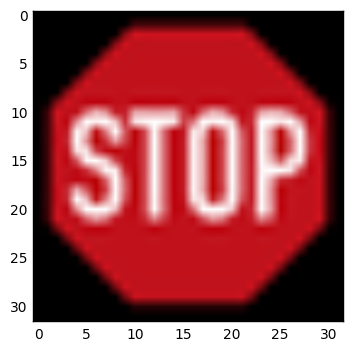

In [23]:
#Pictures 
img=Image.open('stop.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)


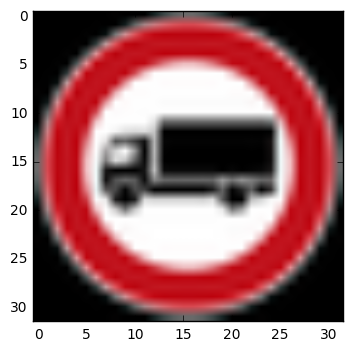

In [24]:
img=Image.open('trump.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr2 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)

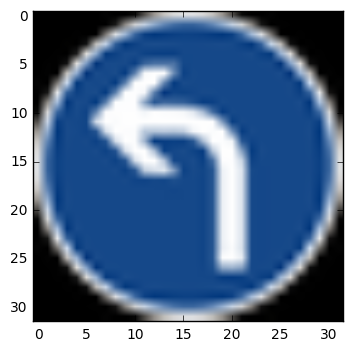

In [25]:
img=Image.open('turnleft.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr3 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)


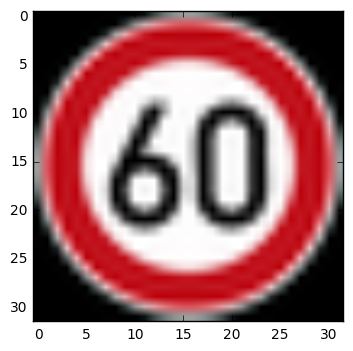

In [26]:
img=Image.open('60kmph.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr4 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)

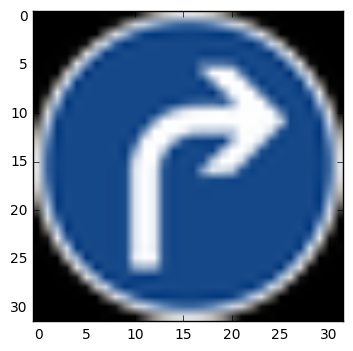

In [27]:
img=Image.open('turnright.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr5 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)

In [28]:
newdata = X_tr
newdata = np.vstack([newdata, X_tr2])
newdata = np.vstack([newdata, X_tr3])
newdata = np.vstack([newdata, X_tr4])
newdata = np.vstack([newdata, X_tr5])
newdata = newdata.reshape(-1, 32*32*3)

In [29]:
a = np.zeros((1,43))

In [30]:
# now add the one in 15th position for the stop sign
a[0,14] = 1

In [31]:
# now add the one in 17th position for the truck sign
b = np.zeros((1,43))
b[0,16]=1

In [32]:
# now add the one in 35th position for the left turn sign
c = np.zeros((1,43))
c[0,34]=1

In [33]:
# now add the one in 4th position for the 60kpm sign
d = np.zeros((1,43))
d[0,3] = 1

In [34]:
# now add the one in 34th position for the right sign
e = np.zeros((1,43))
e[0,33]=1

In [35]:
#make newdata labels
newlabels = a
newlabels = np.vstack([newlabels, b])
newlabels = np.vstack([newlabels, c])
newlabels = np.vstack([newlabels, d])
newlabels = np.vstack([newlabels, e])

In [46]:
# Add an op to initialize the variables.
#prediction = tf.nn.softmax(logits)
init_op = tf.initialize_all_variables()
topFive=tf.nn.top_k(prediction, k=5, sorted=True, name=None)
top_k_feed_dict = {features: newdata}
# Run the tf.nn.top_k operation in the session

with tf.Session() as session:
    # Run the init operation.
    session.run(init_op)
    top_k_pred = (session.run(topFive, feed_dict = top_k_feed_dict))
    #values = np.array([top_k_pred.values])
    #indices = np.array([top_k_pred.indices])
    top5_pred_sftmax = top_k_pred[0]
    top5_pred_labels = top_k_pred[1]

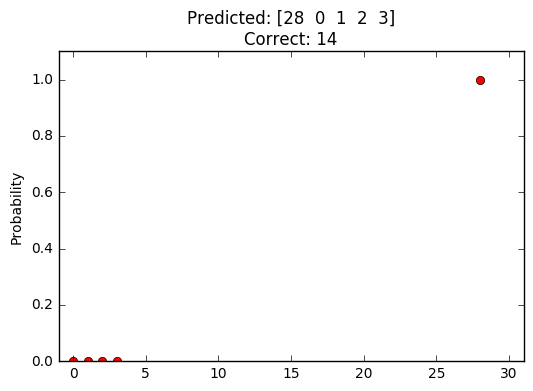

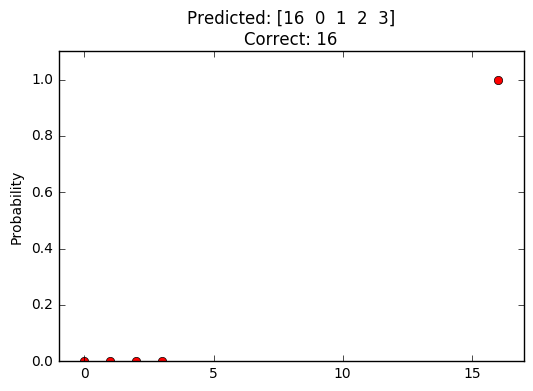

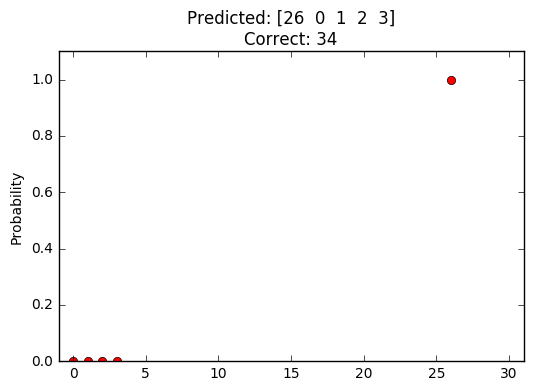

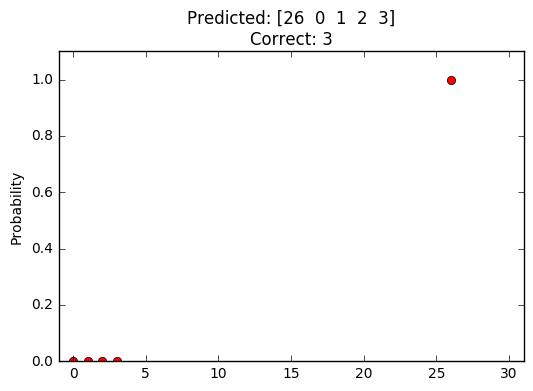

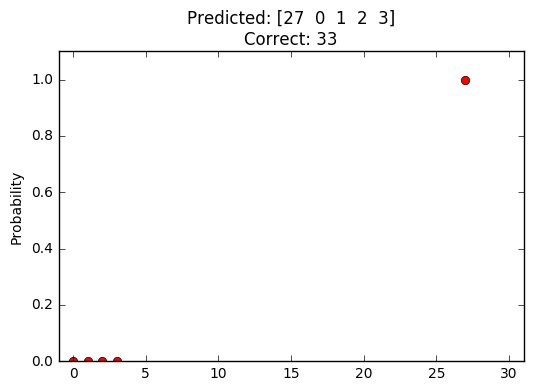

In [47]:
def plot_top_k_probabilities(pred_cls, pred_prob, title):
    plt.plot(list(pred_cls), list(pred_prob), 'ro')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1-1,x2+1,y1,y2+0.1))

    plt.ylabel('Probability')
    plt.title(title)
 
    plt.show()

for i in range(len(top5_pred_sftmax)):
    #predicted_class = top5_pred_labels[i][np.argmax(top5_pred_sftmax [i])]
    predicted_class = top5_pred_labels[i]
    correct_class = np.argmax(newlabels[i])

    plot_title = 'Predicted: {}\nCorrect: {}'.format(predicted_class, correct_class) 
    
    plot_top_k_probabilities(top5_pred_labels[i], top5_pred_sftmax[i], plot_title)
    
    #print('raw top_k results:')
    print('')
    #print('tf.nn.top_k(prediction, 5).values ', list(values[i]))
    #print('tf.nn.top_k(prediction, 5).indices', list(indices[i]))
    
    
    print('')
    print('')

In [38]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

The pickled data dictionary was used to read in the German traffic sign dataset the following attributes.
1.  Image pixel values and color, (32 pixels , 32 pixels, 3 channels)
2.  Labels - the label of the traffic sign
3.  Features, the image pixel values.
4.  Size feature was used to plot the images and sampling areas.
The training and test data is initially extracted from the German traffic signs dataset.  Validation data is generated by duplicating 5% of the training data.


The final architecture of the linear model similar to the TensorFlow lab begins with the Linear Function or logits ,WX + b.  The softmax is estimated the prediction of the traffic sign.  Cross Entropy and loss are calculated.  Loss is the the significant parameter as this calculated value is used to predict the accuracy

For the linear neural model, experimented and decided upon:
    
epochs = 100
batch_size = 20
learning_rate = .24

I choose five German traffic signs from the web.  All five are plotted in the linear neural notebook.  It appears one of my images was not detect.  Perhaps the red stop sign and the red do not enter sign are too similar.  

The difficulty in my five images are they fill the 32X32 pixel more than the trains images.  I took pictures off of the web that are not similar to real German traffic sign pictures uses as training data.
